In [13]:
import os
import cv2
import csv
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import webcolors

In [36]:
'''
submissions: csv file path
scores: models scores or names on the plot
root: data path
'''
submissions = ['/opt/ml/segmentation/baseline_code/submission/30_HRNetV2_OCR_W64_23epoch_rotate+randomsizecrop_0.647.csv','/opt/ml/segmentation/semantic-segmentation-level2-cv-16/dev/model_develop/HRNet/crf_correction.csv','/opt/ml/segmentation/semantic-segmentation-level2-cv-16/dev/model_develop/HRNet/crf_iter_180.csv','/opt/ml/segmentation/semantic-segmentation-level2-cv-16/dev/model_develop/HRNet/crf_iter_180_PSPNet_setting.csv']
scores=['HRNetV2_23epochs_0.682','crf_iter45_0.685','crf_iter180_0.685', 'crf_iter180_PSPNet setting_0.686']
root='/opt/ml/segmentation/input/data/' # 재활용 데이터 경로

In [37]:
class_colormap = [[0,0,0],
               [192,0,128],
               [0,128,192],
               [0,128,64],
               [128,0,0],
               [64,0,128],
               [64,0,192],
               [192,128,64],
               [192,192,128],
               [64,64,128],
               [128,0,192]]
CLASSES = ("Backgroud", "General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")


In [38]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (r, g, b) in enumerate(class_colormap):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [39]:
def visualizations(num_examples, index):
    category_and_rgb = [[CLASSES[idx], (r,g,b)] for idx, (r, g, b) in enumerate(class_colormap)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    images = []
    masks_lst = []
    for idx, submission_path in enumerate(submissions):
        submission = pd.read_csv(submission_path,index_col=None)[index:index + num_examples]
        if idx == 1:
            # image load
            image_ids=submission["image_id"].values
            for i in range(num_examples):
                image_id = image_ids[i]
                image = cv2.imread(os.path.join(root, image_id))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
        masks = submission["PredictionString"].values
        # mask load
        for m in range(num_examples):
            mask = list(map(int, masks[m].split()))
            mask = np.array(mask)
            mask = np.reshape(mask, (-1, 256))
            masks[m] = mask
        masks_lst.append(masks)
    # plt 생성
    fig, ax = plt.subplots(nrows=num_examples, ncols=len(submissions)+1, figsize=(20, 4*num_examples), constrained_layout=True)
    
    for row_num in range(num_examples):
        # Original Image
        ax[row_num][0].imshow(images[row_num])
        ax[row_num][0].set_title(f"Orignal: {image_ids[row_num]}")
        for i in range(len(submissions)):
            # Pred Mask
            ax[row_num][i+1].imshow(label_to_color_image(masks_lst[i][row_num]))
            ax[row_num][i+1].set_title(f"{scores[i]}")
            if i == len(submissions)-1:
                ax[row_num][i+1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

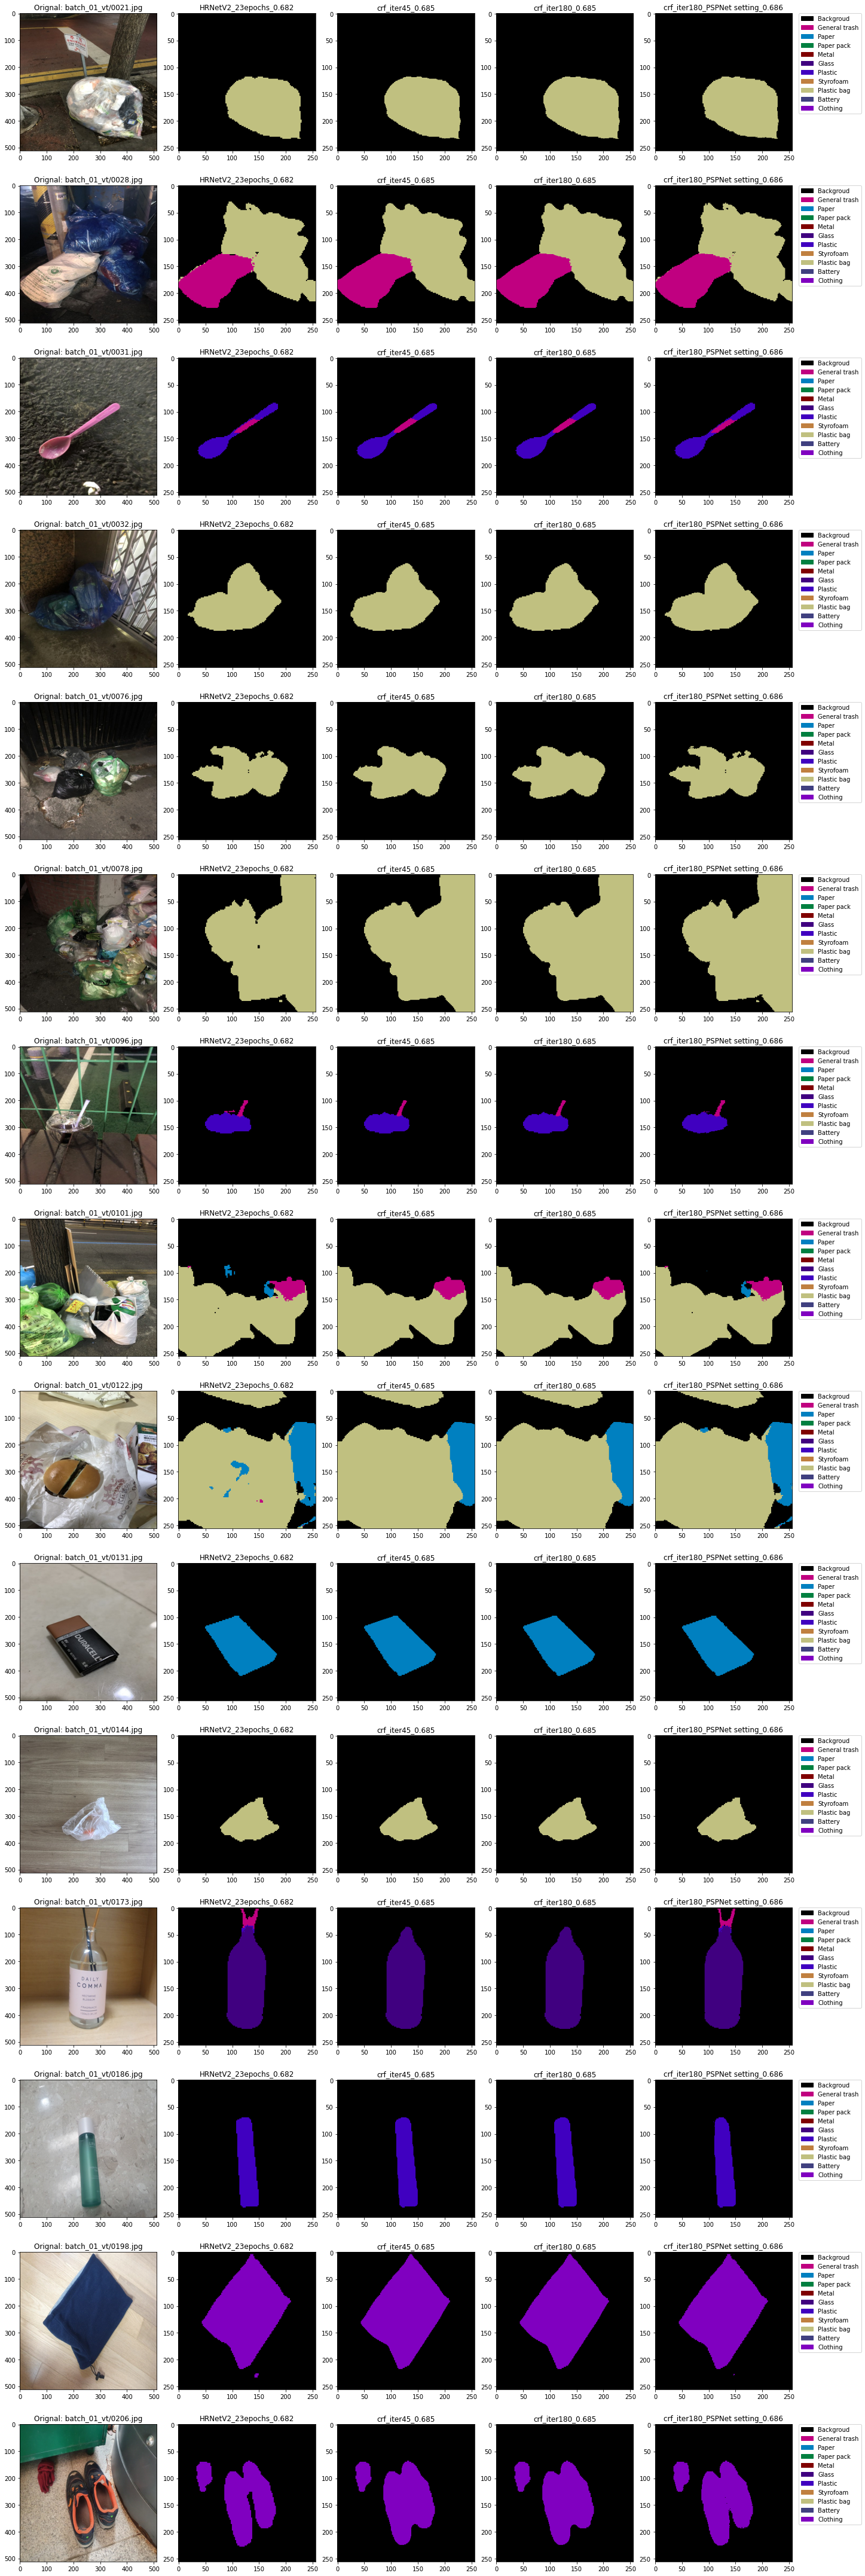

In [40]:
visualizations(15,0) #number, start index

In [ ]:
visualizations(50,50)

In [ ]:
visualizations(50,100)

In [ ]:
visualizations(50,150)

In [ ]:
visualizations(50,200)